In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')
from utils_ccd import get_connection


conn = get_connection()

# Ação - Pós Mandado de Segurança Verbas Transitórias SESAP

In [2]:
sql_nereu = """
SELECT p.numero_processo, p.ano_processo, p.codigo_tipo_processo, p.assunto, 
r.nome, pm.Descricao as marcador, p.IdProcesso as id_processo
FROM processo.dbo.Processos p 
	INNER JOIN processo.dbo.Pro_MarcadorProcesso pmp ON p.IdProcesso = pmp.IdProcesso
	INNER JOIN processo.dbo.Pro_Marcador pm ON pm.IdMarcador = pmp.IdMarcador 
	INNER JOIN processo.dbo.Relator r ON r.codigo = p.codigo_relator 
WHERE setor_atual = 'CCD' 
	AND lower(pm.Descricao) = 'DESCONTO EM FOLHA - Implementar Nereu'
"""
processos_nereu = pd.read_sql(sql_nereu, conn)

In [3]:
processos_nereu

,numero_processo,ano_processo,codigo_tipo_processo,assunto,nome,marcador,id_processo
0,000112,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO GILBERTO DE OLIVEIRA JALES,DESCONTO EM FOLHA - Implementar Nereu,561929
1,000111,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO GILBERTO DE OLIVEIRA JALES,DESCONTO EM FOLHA - Implementar Nereu,561927
2,000137,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Implementar Nereu,561925
3,000110,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Implementar Nereu,561924
4,000113,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Implementar Nereu,561930
...,...,...,...,...,...,...,...
339,004901,2024,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,PAULO ROBERTO CHAVES ALVES,DESCONTO EM FOLHA - Implementar Nereu,607139
340,004895,2024,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,PAULO ROBERTO CHAVES ALVES,DESCONTO EM FOLHA - Implementar Nereu,607123
341,004908,2024,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,FRANCISCO POTIGUAR CAVALCANTI JÚNIOR,DESCONTO EM FOLHA - Implementar Nereu,607230
342,004898,2024,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Implementar Nereu,607127


In [3]:
sql_debitos = '''  
SELECT DISTINCT 
        ed.IdDebito as id_debito,
        pro.numero_processo,
       pro.ano_processo,
       pro.assunto,
       etd.Descricao as tipo_multa,
       edmc.DataFinalImputacaoMultaCominatoria as data_final_cominatoria,
       pm.Descricao as descricao,
       CONCAT(gp.Nome, ' (CPF: ', gp.Documento, ')') as nome,
       processo.dbo.fn_Exe_RetornaValorAtualizado(ed.IdDebito) as valor_multa,
       r.nome as relator,
       ed.IdProcessoOrigem as id_processo_origem,
       (
        SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoOrigem
       ) as processo_origem,
       ed.IdProcessoExecucao as id_processo_execucao,
       (
       SELECT CONCAT(numero_processo, '/', ano_processo)
        FROM processo.dbo.Processos
        WHERE IdProcesso = ed.IdProcessoExecucao
       ) as processo_execucao
	FROM processo.dbo.Processos pro
	INNER JOIN processo.dbo.Pro_MarcadorProcesso pmp ON pmp.IdProcesso = pro.IdProcesso
	INNER JOIN processo.dbo.Pro_Marcador pm ON pmp.IdMarcador = pm.IdMarcador
	INNER JOIN processo.dbo.Relator r ON r.codigo = pro.codigo_relator 
	LEFT JOIN processo.dbo.Exe_Debito ed ON ed.IdProcessoExecucao = pro.IdProcesso
	LEFT JOIN processo.dbo.Exe_DebitoPessoa edp ON edp.IDDebito = ed.IdDebito
	LEFT JOIN processo.dbo.Exe_TipoDebito etd ON etd.CodigoTipoDebito = ed.CodigoTipoDebito
	LEFT JOIN processo.dbo.GenPessoa gp ON gp.IdPessoa = edp.IDPessoa
	LEFT JOIN processo.dbo.Exe_Debito_MultaCominatoria edmc ON ed.IdDebito = edmc.IdDebito
	WHERE pro.setor_atual = 'CCD'
	AND pm.Descricao = 'DESCONTO EM FOLHA - Implementar Nereu'
	AND ed.CodigoStatusDivida = 1
'''

debitos = pd.read_sql(sql_debitos, conn)

debitos['id_processo_origem'] = debitos['id_processo_origem'].fillna(0).astype(int).astype(str)
debitos['id_processo_execucao'] = debitos['id_processo_execucao'].fillna(0).astype(int).astype(str)

debitos_ed = debitos[debitos.relator == 'ANTONIO ED SOUZA SANTANA']
processos_ed = processos_nereu[processos_nereu.nome == 'ANTONIO ED SOUZA SANTANA']

# Ação Conjunta - Gab. Antonio Ed

In [19]:
sql_nereu = """
SELECT p.numero_processo, p.ano_processo, p.codigo_tipo_processo, p.assunto, 
r.nome, pm.Descricao as marcador, p.IdProcesso as id_processo
FROM processo.dbo.Processos p 
	INNER JOIN processo.dbo.Pro_MarcadorProcesso pmp ON p.IdProcesso = pmp.IdProcesso
	INNER JOIN processo.dbo.Pro_Marcador pm ON pm.IdMarcador = pmp.IdMarcador 
	INNER JOIN processo.dbo.Relator r ON r.codigo = p.codigo_relator 
WHERE setor_atual = 'CCD' 
	AND lower(pm.Descricao) = 'DESCONTO EM FOLHA - Implementar Nereu'
"""
processos_nereu = pd.read_sql(sql_nereu, conn)

In [20]:
processos_nereu

,numero_processo,ano_processo,codigo_tipo_processo,assunto,nome,marcador,id_processo
0,012970,2017,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,CARLOS THOMPSON COSTA FERNANDES,DESCONTO EM FOLHA - Implementar Nereu,456732
1,002720,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,PAULO ROBERTO CHAVES ALVES,DESCONTO EM FOLHA - Implementar Nereu,566447
2,000098,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Implementar Nereu,561835
3,000099,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Implementar Nereu,561836
4,000101,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO GILBERTO DE OLIVEIRA JALES,DESCONTO EM FOLHA - Implementar Nereu,561900
...,...,...,...,...,...,...,...
339,004872,2024,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,PAULO ROBERTO CHAVES ALVES,DESCONTO EM FOLHA - Implementar Nereu,606399
340,004901,2024,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,PAULO ROBERTO CHAVES ALVES,DESCONTO EM FOLHA - Implementar Nereu,607139
341,000855,2025,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO GILBERTO DE OLIVEIRA JALES,DESCONTO EM FOLHA - Implementar Nereu,611319
342,000880,2025,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,PAULO ROBERTO CHAVES ALVES,DESCONTO EM FOLHA - Implementar Nereu,612847


In [26]:
processos_gilberto = processos_nereu[processos_nereu.nome.str.contains('GILBERTO')]

In [25]:
debitos.relator.unique()

array(['CARLOS THOMPSON COSTA FERNANDES', 'ANTONIO ED SOUZA SANTANA',
       'ANTONIO GILBERTO DE OLIVEIRA JALES', 'PAULO ROBERTO CHAVES ALVES'],
      dtype=object)

In [15]:
debitos_ed = debitos[debitos.relator == 'ANTONIO ED SOUZA SANTANA']
processos_ed = processos_nereu[processos_nereu.nome == 'ANTONIO ED SOUZA SANTANA']

In [16]:
debitos_ed

,id_debito,numero_processo,ano_processo,assunto,tipo_multa,data_final_cominatoria,descricao,nome,valor_multa,relator,id_processo_origem,processo_origem,id_processo_execucao,processo_execucao


## Estatísticas

In [8]:
'000096' in processos_ed['numero_processo'].unique().astype(list)

False

In [9]:
nereu_relator = processos_nereu.groupby('nome').numero_processo.count().reset_index().sort_values('numero_processo', ascending=False)

In [10]:
nereu_relator.columns = ['Relator', 'Quantidade']

In [11]:
nereu_relator

,Relator,Quantidade


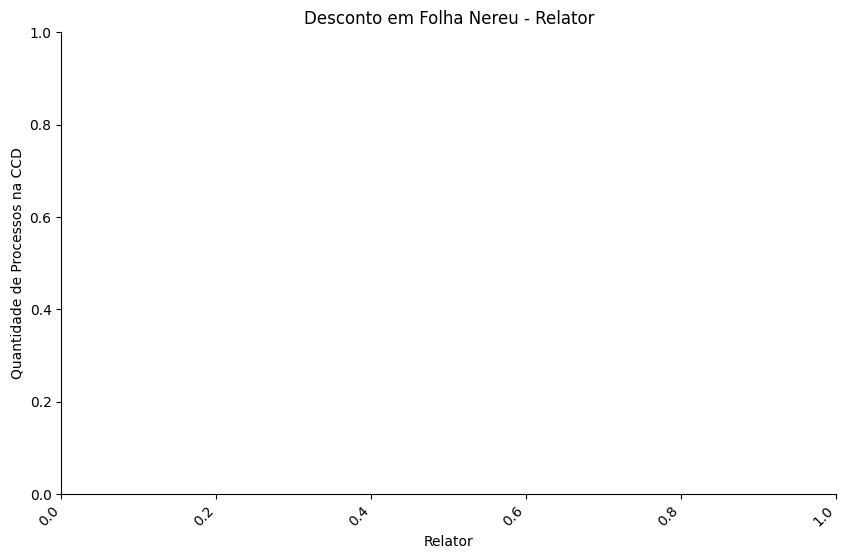

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(data=nereu_relator, x='Relator', y='Quantidade', palette='viridis')
plt.xticks(rotation=45, ha='right')
sns.despine(right=True, top=True)
plt.title('Desconto em Folha Nereu - Relator')
plt.xlabel('Relator')
plt.ylabel('Quantidade de Processos na CCD')
plt.show()

In [9]:
graph_debitos = debitos_ed.groupby('tipo_multa').agg({'valor_multa': 'sum', 'numero_processo': 'count'}).reset_index()

In [10]:
pd.options.display.float_format = '{:,.2f}'.format

In [11]:
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

In [12]:
graph_debitos.valor_multa.sum()

2034159.04

In [13]:
#graph_debitos.columns = ['Tipo de Multa', 'Valor Total', 'Quantidade de Processos']
#graph_debitos['Valor Total'] = graph_debitos['Valor Total'].apply(lambda x: locale.currency(x, grouping=True))    
#graph_debitos['Quantidade de Processos'] = graph_debitos['Quantidade de Processos'].astype(int)

/tmp/ipykernel_244845/4127177992.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=graph_debitos, x='tipo_multa', y='valor_multa', palette='viridis')


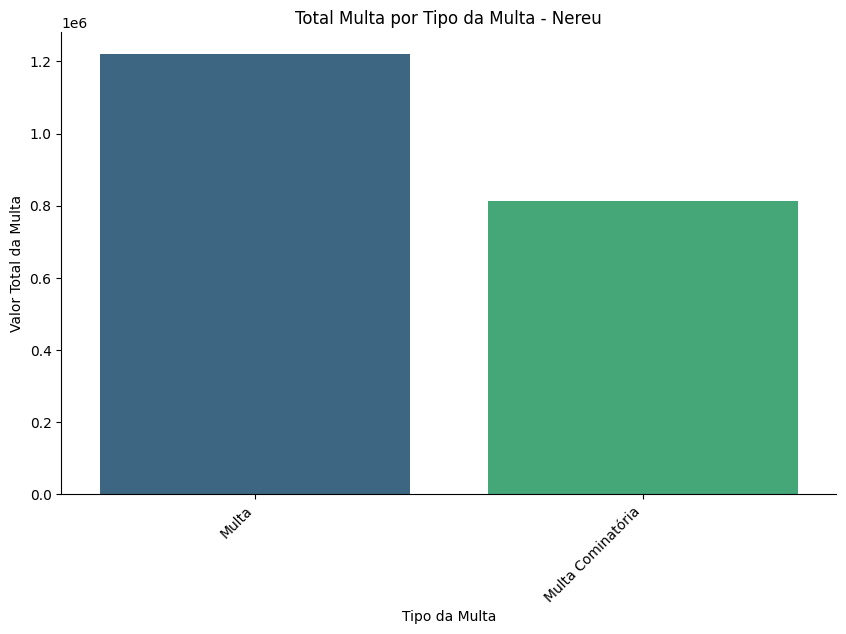

In [15]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=graph_debitos, x='tipo_multa', y='valor_multa', palette='viridis')
plt.xticks(rotation=45, ha='right')
sns.despine(right=True, top=True)
plt.title('Total Multa por Tipo da Multa - Nereu')
plt.xlabel('Tipo da Multa')
plt.ylabel('Valor Total da Multa')
plt.show()

In [16]:
import locale

# Set locale to Brazilian Portuguese
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

# Sum of valor_multa
total_valor_multa = graph_debitos['valor_multa'].sum()

# Print the sum in BRL currency format
print(locale.currency(total_valor_multa, grouping=True))

R$ 2.034.159,04


## Processos originários

In [17]:
processos_ed['processo'] = processos_ed['numero_processo'].astype(str) + '/' + processos_ed['ano_processo'].astype(str)

/tmp/ipykernel_244845/475517431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processos_ed['processo'] = processos_ed['numero_processo'].astype(str) + '/' + processos_ed['ano_processo'].astype(str)


In [18]:
sql_orig = '''
SELECT * FROM 
processo.dbo.Processos pro
WHERE IdProcesso IN ({})
'''
df_orig = pd.read_sql(
    sql_orig.format(','.join(["'{}'".format(i) for i in debitos_ed['id_processo_origem'].unique()])),
    conn
)
df_orig['processo'] = df_orig['numero_processo'].astype(str) + '/' + df_orig['ano_processo'].astype(str)


/tmp/ipykernel_244845/2970968769.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_orig = pd.read_sql(


## Processo 3474/2021 - Lista de processos para retirar

In [4]:

df_planilha_1 = pd.read_excel('docs/planilha_processos_nereu_cut.xlsx', sheet_name='Table 1')
df_planilha_2 = pd.read_excel('docs/planilha_processos_nereu_cut.xlsx', sheet_name='Table 2')
df_planilha_3 = pd.read_excel('docs/planilha_processos_nereu_cut.xlsx', sheet_name='Table 3')
df_planilha_4 = pd.read_excel('docs/planilha_processos_nereu_cut.xlsx', sheet_name='Table 4')
df_planilha = pd.concat([df_planilha_1, df_planilha_2, df_planilha_3, df_planilha_4])
df_planilha['Nº do Processo'].fillna('/', inplace=True)
df_planilha['numero_processo'] = df_planilha['Nº do Processo'].apply(lambda x: x.split('/')[0].strip())
df_planilha['ano_processo'] = df_planilha['Nº do Processo'].apply(lambda x: x.split('/')[1].strip())
df_planilha['processo'] = df_planilha['numero_processo'] + '/' + df_planilha['ano_processo']

C:\Users\05911205424\AppData\Local\Temp\ipykernel_16060\3079761462.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_planilha['Nº do Processo'].fillna('/', inplace=True)


In [6]:
def in_processo_3474_2021(processo):
    return 'SIM' if len(df_planilha[df_planilha['processo'].isin([processo])]) else 'NÃO'

debitos_ed['esta_no_processo_3474_2021'] = debitos_ed['processo_origem'].apply(in_processo_3474_2021)
#debitos_ed['valor_multa'] = debitos_ed['valor_multa'].apply(lambda x: locale.currency(x, grouping=True, symbol=False))
debitos_ed['data_final_cominatoria'] = pd.to_datetime(debitos_ed['data_final_cominatoria']).dt.strftime('%d/%m/%Y')   

C:\Users\05911205424\AppData\Local\Temp\ipykernel_16060\1746551077.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debitos_ed['esta_no_processo_3474_2021'] = debitos_ed['processo_origem'].apply(in_processo_3474_2021)
C:\Users\05911205424\AppData\Local\Temp\ipykernel_16060\1746551077.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debitos_ed['data_final_cominatoria'] = pd.to_datetime(debitos_ed['data_final_cominatoria']).dt.strftime('%d/%m/%Y')


In [7]:
debitos['esta_no_processo_3474_2021'] = debitos['processo_origem'].apply(in_processo_3474_2021)

In [12]:
debitos_liberados = debitos[(debitos['esta_no_processo_3474_2021'] == 'NÃO')]

In [15]:
debitos_liberados['valor_multa_reais'] = debitos_liberados['valor_multa'].apply(lambda x: locale.currency(x, grouping=True, symbol=False))

C:\Users\05911205424\AppData\Local\Temp\ipykernel_16060\1827484155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debitos_liberados['valor_multa_reais'] = debitos_liberados['valor_multa'].apply(lambda x: locale.currency(x, grouping=True, symbol=False))


In [16]:
debitos_liberados.columns

Index(['id_debito', 'numero_processo', 'ano_processo', 'assunto', 'tipo_multa',
       'data_final_cominatoria', 'descricao', 'nome', 'valor_multa', 'relator',
       'id_processo_origem', 'processo_origem', 'id_processo_execucao',
       'processo_execucao', 'esta_no_processo_3474_2021', 'valor_multa_reais'],
      dtype='object')

In [20]:
debitos_liberados[['id_debito', 'processo_origem', 
                   'processo_execucao', 'valor_multa', 
                   'relator', 'tipo_multa',
       'data_final_cominatoria']].\
              to_excel('docs/debitos_liberados_nereu.xlsx', index=False)

In [49]:
debitos_gilberto = debitos[debitos.relator.str.contains('GILBERTO') & (debitos['esta_no_processo_3474_2021'] == 'NÃO')]

In [55]:
debitos_gilberto['valor_multa_reais'] = debitos_gilberto['valor_multa'].apply(lambda x: locale.currency(x, grouping=True, symbol=False))

C:\Users\05911205424\AppData\Local\Temp\ipykernel_6736\2612748464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debitos_gilberto['valor_multa_reais'] = debitos_gilberto['valor_multa'].apply(lambda x: locale.currency(x, grouping=True, symbol=False))


In [57]:
debitos_gilberto.valor_multa_reais

4     27.009,69
8     14.305,55
9     14.305,55
11    14.440,02
12    14.305,55
13    14.305,55
14    14.440,02
15    14.305,55
17    36.442,12
24     1.398,47
27     1.387,95
28     1.398,47
31     1.366,63
34     1.348,21
35     1.377,42
37     1.366,63
39     1.387,95
41    14.107,61
42    15.141,94
45    13.588,37
46    13.447,17
47    13.464,29
49    13.733,80
51     1.333,05
52     1.252,51
56    13.696,72
58    10.873,78
59     8.985,10
Name: valor_multa, dtype: object

In [60]:
debitos_gilberto.sort_values(by='valor_multa', ascending=False)[['processo_origem', 'processo_execucao', 'valor_multa_reais']]

,processo_origem,processo_execucao,valor_multa_reais
17,004784/2013,001361/2022,"36.442,12"
4,016395/2016,000133/2022,"27.009,69"
42,014369/2017,003061/2022,"15.141,94"
14,001202/2016,000129/2022,"14.440,02"
11,004874/2017,000152/2022,"14.440,02"
9,004165/2017,000116/2022,"14.305,55"
13,007606/2017,000111/2022,"14.305,55"
8,002545/2017,000112/2022,"14.305,55"
15,001302/2017,000125/2022,"14.305,55"
12,005552/2017,000115/2022,"14.305,55"


In [ ]:
tab_debitos_ed = debitos_ed[['id_debito', 'processo_origem', 
                             'processo_execucao', 'tipo_multa', 'valor_multa', 
                             'data_final_cominatoria', 'esta_no_processo_3474_2021']]

In [50]:
tab_debitos_ed.to_excel('docs/debitos_ed.xlsx', index=False)

In [2]:
tab_debitos_ed = pd.read_excel('docs/debitos_ed.xlsx')

In [3]:
tab_debitos_ed

,id_debito,processo_origem,processo_execucao,tipo_multa,valor_multa,data_final_cominatoria,esta_no_processo_3474_2021
0,21475,101908/2018,000137/2022,Multa,14149.9480,NaN,SIM
1,21476,101678/2018,000135/2022,Multa,14149.9480,16/12/2021,NÃO
2,21477,101184/2018,000134/2022,Multa,13878.9334,16/12/2021,NÃO
3,21481,017996/2017,000151/2022,Multa,14106.3356,NaN,SIM
4,21530,003603/2016,000131/2022,Multa,12774.7385,NaN,NÃO
...,...,...,...,...,...,...,...
153,27531,101880/2019,003382/2024,Multa Cominatória,12522.9487,29/01/2022,SIM
154,27532,101636/2019,003380/2024,Multa Cominatória,13185.1262,30/08/2021,SIM
155,27533,101759/2019,003397/2024,Multa Cominatória,12999.1271,05/09/2021,SIM
156,27534,101696/2019,003394/2024,Multa Cominatória,12384.3440,04/02/2022,NÃO


In [4]:
tab_debitos_ed.processo_execucao.nunique()

158

In [5]:
tab_debitos_ed.valor_multa.sum()

np.float64(2034159.0400000003)

## Checar Informação Consultoria Jurídica

In [23]:
processos_ed['processo'] = processos_ed['numero_processo'].astype(str) + '/' + processos_ed['ano_processo'].astype(str)

/tmp/ipykernel_244845/475517431.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processos_ed['processo'] = processos_ed['numero_processo'].astype(str) + '/' + processos_ed['ano_processo'].astype(str)


In [24]:
sql_informacoes = '''
SELECT *
FROM vw_ata_informacao
WHERE CONCAT(numero_processo, '/', ano_processo) IN ({})
'''

df_informacoes_origem = pd.read_sql(sql_informacoes.format(','.join([f"'{x}'" for x in debitos_ed['processo_origem'].unique()])), conn)

/tmp/ipykernel_244845/1801061274.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_informacoes_origem = pd.read_sql(sql_informacoes.format(','.join([f"'{x}'" for x in debitos_ed['processo_origem'].unique()])), conn)


In [25]:
df_informacoes_origem[df_informacoes_origem.setor == 'CONJU']

,setor,numero_processo,ano_processo,ordem,data_resumo,resumo,sigilo,usuario,data_ultima_atualizacao,informacao_efetuada_por,...,Inativa,DataPublicacao,IdInformacaoSubstituida,UsuarioInformacaoSubstituida,DataInformacaoSubstituida,IdTipoParecer,Observacao,IdProcesso,E_Relatorio_Inicial,E_Relatorio_Auditoria


In [26]:
sql_informacoes = '''
SELECT *
FROM vw_ata_informacao
WHERE CONCAT(numero_processo, '/', ano_processo) IN ({})
'''

df_informacoes = pd.read_sql(sql_informacoes.format(','.join([f"'{x}'" for x in processos_ed['processo'].unique()])), conn)

/tmp/ipykernel_244845/3682414726.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_informacoes = pd.read_sql(sql_informacoes.format(','.join([f"'{x}'" for x in processos_ed['processo'].unique()])), conn)


## Informação Processo 000096/2022

In [27]:
processos_ed['codigo_tipo_processo'].unique()

array(['EXE'], dtype=object)

In [28]:
df_informacoes['processo'] = df_informacoes['numero_processo'].astype(str) + '/' + df_informacoes['ano_processo'].astype(str)

In [29]:
df_informacoes['resumo'].fillna('', inplace=True)

In [30]:
com_protesto = df_informacoes[df_informacoes['resumo'].str.contains('PROTESTO')]

In [31]:
com_protesto

,setor,numero_processo,ano_processo,ordem,data_resumo,resumo,sigilo,usuario,data_ultima_atualizacao,informacao_efetuada_por,...,DataPublicacao,IdInformacaoSubstituida,UsuarioInformacaoSubstituida,DataInformacaoSubstituida,IdTipoParecer,Observacao,IdProcesso,E_Relatorio_Inicial,E_Relatorio_Auditoria,processo
1555,DAE_SEI,000096,2022,43,2022-10-07 14:00:18.023,PROTESTO SEM ÊXITO...,None,49766210225,2022-10-07 14:00:18.023,49766210225,...,2022-10-07 14:02:05.477,None,None,None,None,None,None,None,None,000096/2022
1559,DAE_SEI,000098,2022,51,2022-10-07 14:02:34.163,PROTESTO SEM ÊXITO...,None,49766210225,2022-10-07 14:02:34.163,49766210225,...,2022-10-07 14:03:48.780,None,None,None,None,None,None,None,None,000098/2022
3808,DAE_SEI,001385,2022,43,2023-02-16 09:54:51.717,PROTESTO SEM ÊXITO...,None,49766210225,2023-02-16 09:54:51.717,49766210225,...,2023-02-16 09:56:28.460,None,None,None,None,None,None,None,None,001385/2022
3922,DAE_SEI,001386,2022,50,2023-01-17 10:35:19.773,PROTESTO SEM ÊXITO...,None,49766210225,2023-01-17 10:35:19.773,49766210225,...,2023-01-17 10:36:49.327,None,None,None,None,None,None,None,None,001386/2022
5387,DAE_SEI,002564,2024,52,2024-08-15 09:43:51.857,PROTESTO SEM ÊXITO...,None,49766210225,2024-08-15 09:43:51.857,49766210225,...,2024-08-15 09:48:10.593,None,None,None,None,None,None,None,None,002564/2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8666,DAE_SEI,002582,2024,47,2024-10-09 10:43:36.557,PROTESTO SEM ÊXITO...,None,49766210225,2024-10-09 10:43:36.557,49766210225,...,2024-10-09 10:45:57.490,None,None,None,None,None,None,None,None,002582/2024
8687,DAE_SEI,002580,2024,50,2024-10-09 11:25:02.727,PROTESTO SEM ÊXITO...,None,49766210225,2024-10-09 11:25:02.727,49766210225,...,2024-10-09 11:27:02.913,None,None,None,None,None,None,None,None,002580/2024
8744,DAE_SEI,002567,2024,52,2024-10-10 11:03:22.623,PROTESTO SEM ÊXITO...,None,49766210225,2024-10-10 11:03:22.623,49766210225,...,2024-10-10 11:05:05.283,None,None,None,None,None,None,None,None,002567/2024
8749,DAE_SEI,002566,2024,49,2024-10-10 11:05:59.203,PROTESTO SEM ÊXITO...,None,49766210225,2024-10-10 11:05:59.203,49766210225,...,2024-10-10 11:07:18.240,None,None,None,None,None,None,None,None,002566/2024


In [32]:
processos_ed[~processos_ed.processo.isin(com_protesto['processo'])]

,numero_processo,ano_processo,codigo_tipo_processo,assunto,nome,marcador,id_processo,processo
4,000099,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Nereu,561836,000099/2022
6,000110,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Nereu,561924,000110/2022
7,000137,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Nereu,561925,000137/2022
10,000113,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Nereu,561930,000113/2022
11,000114,2022,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Nereu,561931,000114/2022
...,...,...,...,...,...,...,...,...
326,003397,2024,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Nereu,604844,003397/2024
327,003401,2024,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Nereu,605437,003401/2024
328,003409,2024,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Nereu,605629,003409/2024
329,003410,2024,EXE,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,ANTONIO ED SOUZA SANTANA,DESCONTO EM FOLHA - Nereu,605634,003410/2024


In [33]:
debitos_ed['processo'] = debitos_ed['numero_processo'].astype(str) + '/' + debitos_ed['ano_processo'].astype(str)

/tmp/ipykernel_244845/2177528228.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  debitos_ed['processo'] = debitos_ed['numero_processo'].astype(str) + '/' + debitos_ed['ano_processo'].astype(str)


## Mudança após reunião 15/05/2025

In [ ]:
fora_processo_dap = debitos_ed[debitos_ed['esta_no_processo_3474_2021'] == 'NÃO']

In [52]:
fora_processo_dap

,id_debito,numero_processo,ano_processo,assunto,tipo_multa,data_final_cominatoria,descricao,nome,valor_multa,relator,id_processo_origem,processo_origem,id_processo_execucao,processo_execucao,esta_no_processo_3474_2021
2,21476,000135,2022,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,Multa,16/12/2021,DESCONTO EM FOLHA - Nereu,NEREU BATISTA LINHARES (CPF: 13006444434),"14,149.95",ANTONIO ED SOUZA SANTANA,486978,101678/2018,562040,000135/2022,NÃO
3,21477,000134,2022,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,Multa,16/12/2021,DESCONTO EM FOLHA - Nereu,NEREU BATISTA LINHARES (CPF: 13006444434),"13,878.93",ANTONIO ED SOUZA SANTANA,482410,101184/2018,562037,000134/2022,NÃO
5,21530,000131,2022,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,Multa,NaN,DESCONTO EM FOLHA - Nereu,NEREU BATISTA LINHARES (CPF: 13006444434),"12,774.74",ANTONIO ED SOUZA SANTANA,406801,003603/2016,562014,000131/2022,NÃO
6,21532,000119,2022,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,Multa,NaN,DESCONTO EM FOLHA - Nereu,NEREU BATISTA LINHARES (CPF: 13006444434),"12,024.74",ANTONIO ED SOUZA SANTANA,432578,025727/2016,561981,000119/2022,NÃO
10,21543,000148,2022,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,Multa,NaN,DESCONTO EM FOLHA - Nereu,NEREU BATISTA LINHARES (CPF: 13006444434),"12,811.67",ANTONIO ED SOUZA SANTANA,451662,010487/2017,562076,000148/2022,NÃO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,27390,002023,2024,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,Multa Cominatória,30/12/2021,DESCONTO EM FOLHA - Nereu,NEREU BATISTA LINHARES (CPF: 13006444434),"12,620.63",ANTONIO ED SOUZA SANTANA,490302,102158/2018,599449,002023/2024,NÃO
322,27393,002040,2024,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,Multa Cominatória,30/12/2021,DESCONTO EM FOLHA - Nereu,NEREU BATISTA LINHARES (CPF: 13006444434),"12,620.63",ANTONIO ED SOUZA SANTANA,493626,102534/2018,599595,002040/2024,NÃO
324,27518,000142,2023,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,Multa Cominatória,08/07/2020,DESCONTO EM FOLHA - Nereu,NEREU BATISTA LINHARES (CPF: 13006444434),"9,602.34",ANTONIO ED SOUZA SANTANA,53866,003708/2006,579259,000142/2023,NÃO
326,27526,003409,2024,EXECUÇÃO DA DECISÃO PROFERIDA NOS AUTOS DO PRO...,Multa Cominatória,21/01/2023,DESCONTO EM FOLHA - Nereu,NEREU BATISTA LINHARES (CPF: 13006444434),"11,601.08",ANTONIO ED SOUZA SANTANA,494304,100004/2019,605629,003409/2024,NÃO


In [36]:
processos_fora = fora_processo_dap['processo'].unique().tolist()

In [41]:
len(processos_fora)

99

In [ ]:
fora_processo_dap.columns

Index(['id_debito', 'numero_processo', 'ano_processo', 'assunto', 'tipo_multa',
       'data_final_cominatoria', 'descricao', 'nome', 'valor_multa', 'relator',
       'id_processo_origem', 'processo_origem', 'id_processo_execucao',
       'processo_execucao', 'esta_no_processo_3474_2021', 'processo'],
      dtype='object')

In [39]:
tab_fora = fora_processo_dap[['id_debito', 'processo_origem', 'processo_execucao', 'tipo_multa', 'valor_multa', 'data_final_cominatoria']]

In [40]:
tab_fora.to_excel('docs/debitos_fora_processo_dap.xlsx', index=False)

In [42]:
len(fora_processo_dap)

99

In [60]:
tab_tmp = fora_processo_dap.groupby('tipo_multa').valor_multa.sum().reset_index().sort_values('valor_multa', ascending=False)
tab_tmp['valor_multa'] = tab_tmp['valor_multa'].apply(lambda x: locale.currency(x, grouping=True, symbol=True))
tab_tmp

,tipo_multa,valor_multa
0,Multa,"R$ 698.322,82"
1,Multa Cominatória,"R$ 573.929,25"


In [57]:
locale.currency(fora_processo_dap.valor_multa.sum(), grouping=True, symbol=True)   

'R$ 1.272.252,07'